<a href="https://colab.research.google.com/github/StefanoGenettiUniTN/appa-chinquinaria/blob/data-visualization/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data visualization

## Data export bollettino APPA
**Date:** 2025-09-30

**Source:** [link](https://bollettino.appa.tn.it/aria/scarica)

In this section we try to visualize data from bollettino APPA from 2023-01-01 to 2023-03-01. Indeed from the website it is possible to download data within maximum 90 days interval.

**Note:** you can select multiple "Stazioni" and multiple "Inquinanti" by pressing Ctrl and select the items.

In [50]:
%%shell
if [ ! -f "appa-export.csv" ]; then
  gdown -q 1JDDMzu7Jo1polnxJ249Tthim5MaVdTpb -O appa-export.csv
fi

In [68]:
import os
import pandas as pd
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import zipfile
import io
from ipywidgets import interact, widgets
from typing import List, Tuple, Dict, Any, Optional
from datetime import datetime, date

In [52]:
file_path: str = "appa-export.csv"
df: pd.DataFrame = pd.read_csv(file_path, encoding="latin1")

# parse datetime
# replace '24' in 'Ora' with '0' and handle the date increment
# convert Valore to numeric
df['datetime'] = pd.to_datetime(df['Data'] + ' ' + df['Ora'].replace(24, 0).astype(str) + ':00:00')
df.loc[df['Ora'] == 24, 'datetime'] += pd.Timedelta(days=1)
df['Valore'] = pd.to_numeric(df['Valore'], errors="coerce")  # sometimes valore is n.d. with this it is converted to NaN

# unique options
stations: List[str] = df['Stazione'].unique()
pollutants: List[str] = df['Inquinante'].unique()
min_date: pd.Timestamp = df['datetime'].min()
max_date: pd.Timestamp = df['datetime'].max()
min_hour: int = df['Ora'].min()
max_hour: int = df['Ora'].max()

# interactive plot function
def plot_air_quality( selected_stations: List[str],
                      selected_pollutants: List[str],
                      start_date: date,
                      end_date: date,
                      hour_range: Tuple[int, int]) -> None:
    filtered = df[
        (df['Stazione'].isin(selected_stations)) &
        (df['Inquinante'].isin(selected_pollutants)) &
        (df['datetime'] >= pd.to_datetime(start_date)) &
        (df['datetime'] <= pd.to_datetime(end_date)) &
        (df['Ora'] >= hour_range[0]) &
        (df['Ora'] <= hour_range[1])
    ]

    plt.figure(figsize=(12,6))
    for station, group in filtered.groupby("Stazione"):
        for pollutant, sub_group in group.groupby("Inquinante"):
            plt.plot(sub_group["datetime"], sub_group["Valore"], marker='o', label=f"{station} - {pollutant}")

    plt.title("Andamento inquinanti per stazione")
    plt.xlabel("Tempo")
    plt.ylabel("Valore (µg/mc)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # format datetime
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # auto-set tick positions
    plt.xticks(rotation=45, ha='right')  # rotate labels
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# === widgets ==================================================================
station_widget = widgets.SelectMultiple(
    options=stations,
    value=[stations[0]],
    description='Stazioni',
    disabled=False
)

pollutant_widget = widgets.SelectMultiple(
    options=pollutants,
    value=[pollutants[0]],
    description='Inquinanti',
    disabled=False
)

start_date_widget = widgets.DatePicker(
    value=min_date.date(),
    description='Start Date'
)

end_date_widget = widgets.DatePicker(
    value=max_date.date(),
    description='End Date'
)

hour_range_widget = widgets.IntRangeSlider(
    value=[min_hour, max_hour],
    min=0,
    max=24,
    step=1,
    description='Hour Range',
    continuous_update=False,
    layout={'width': '500px'}
)
# ==============================================================================

interact(
    plot_air_quality,
    selected_stations=station_widget,
    selected_pollutants=pollutant_widget,
    start_date=start_date_widget,
    end_date=end_date_widget,
    hour_range=hour_range_widget
)

interactive(children=(SelectMultiple(description='Stazioni', index=(0,), options=('Parco S. Chiara', 'Via Bolz…

<function __main__.plot_air_quality(selected_stations: List[str], selected_pollutants: List[str], start_date: datetime.date, end_date: datetime.date, hour_range: Tuple[int, int]) -> None>

## Data export European Environment Agency

The purpose of this section is to process PM10 data from European Environment Agency (EEA) API. It would be nice to display the map of Italy with each station as a point and connect the stations with graph edges with edge size proportional to the correlation between stations. At the end of the section we align EEA data with APPA.

In [53]:
# get metadata from google drive: csv file with the vocabulary with station data. Can be also downloaded from https://discomap.eea.europa.eu/App/AQViewer/index.html?fqn=Airquality_Dissem.b2g.measurements#
%%shell
if [ ! -f "metadata-vocabulary-italy.csv" ]; then
  gdown -q 1_u0CXivDI1kTpTOcBgOPysFtOXKsUfjs -O metadata-vocabulary-italy.csv
fi

In [54]:
# API parameters
apiUrl: str = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/"
metadata_vocabulary = "metadata-vocabulary-italy.csv"
pollutant_dict: Dict[str, str] = {
    "PM10": "http://dd.eionet.europa.eu/vocabulary/aq/pollutant/5"
}
endpoint: str = "ParquetFile"

api_countries: List[str] = ["IT"]
api_cities: List[str] = []
api_pollutants: List[str] = ["PM10"]
api_dateTimeStart: str = "2023-01-01"
api_dateTimeEnd: str = "2023-03-01"
api_aggregationType: str = "hour"

# EEA zip file with air pollution data
zip_eea_parquet: str = "eea-pm10-italy.zip"
if not os.path.exists(zip_eea_parquet):
  # request body
  request_body: Dict[str, Any] = {
      "countries": api_countries, # List[str]
      "cities": api_cities, # List[str]
      "pollutants": api_pollutants, # List[str]
      "dataset": 2, # int
      "dateTimeStart": f"{api_dateTimeStart}T00:00:00.000Z",  # str
      "dateTimeEnd": f"{api_dateTimeEnd}T23:59:00.000Z",  # str
      "aggregationType": f"{api_aggregationType}",  # str
      "email": None # str
  }

  # a get request to the API
  print("Requesting zip file from API...")
  downloadFile = requests.post(apiUrl+endpoint, json=request_body).content

  # store in local path
  output = open(zip_eea_parquet, 'wb')
  output.write(downloadFile)
  output.close()
  print(f"Downloaded zip file from API and saved to {zip_eea_parquet}")

# extract parquet files from zip archive
eea_parquet_folder: str = "eea-pm10-italy"
if not os.path.exists(eea_parquet_folder):
  os.makedirs(eea_parquet_folder)
with zipfile.ZipFile(zip_eea_parquet, 'r') as zip_ref:
  zip_ref.extractall(eea_parquet_folder)
parquet_files = [os.path.join(f"{eea_parquet_folder}/E1a", f) for f in os.listdir(f"{eea_parquet_folder}/E1a") if f.endswith('.parquet')]
print(f"Found {len(parquet_files)} parquet files")

# convert parquet files to csv
eea_csv = "eea-pm10-italy.csv"
df_list = [pd.read_parquet(pf) for pf in parquet_files]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv(eea_csv, index=False)
print(f"CSV saved to {eea_csv}")

# merge the eea data with the metadata vocabularies
eea_csv_with_metadata = "eea-pm10-italy-full.csv"
df_metadata = pd.read_csv(metadata_vocabulary)
df_eea = pd.read_csv(eea_csv)
df_eea['station-id'] = df_eea['Samplingpoint'].str.split("IT/").str[-1]
df_metadata['station-id'] = df_metadata["Sampling Point Id"]
df_merged = pd.merge(df_eea, df_metadata, on="station-id", how="left", indicator=True)
df_unmatched = df_merged[df_merged["_merge"] == "left_only"]
print(f"Unmatched rows saved as unmatched_measurements.csv (total: {len(df_unmatched)})")
# filter relevant columns
columns_to_keep = [
    "station-id",
    "Start", # Include 'Start'
    "End", # Include 'End'
    "Value",
    "Unit",
    "AggType",
    "Country",
    "Air Pollutant",
    "Longitude",
    "Latitude",
    "Altitude",
    "Altitude Unit",
    "Air Quality Station Area",
    "Air Quality Station Type",
    "Municipality",
    "Duration Unit",
    "Cadence Unit"
]
df_filtered = df_merged[columns_to_keep]
df_filtered.to_csv(eea_csv_with_metadata, index=False)
print(f"Merged CSV saved to {eea_csv_with_metadata}")

print("\nPreview of the dataset:")
display(df_filtered.head(10))

Found 122 parquet files
CSV saved to eea-pm10-italy.csv
Unmatched rows saved as unmatched_measurements.csv (total: 0)
Merged CSV saved to eea-pm10-italy-full.csv

Preview of the dataset:


,station-id,Start,End,Value,Unit,AggType,Country,Air Pollutant,Longitude,Latitude,Altitude,Altitude Unit,Air Quality Station Area,Air Quality Station Type,Municipality,Duration Unit,Cadence Unit
0,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 00:00:00,2023-01-01 01:00:00,83.9,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
1,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,106.8,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
2,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,57.1,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
3,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,43.5,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
4,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 04:00:00,2023-01-01 05:00:00,34.6,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
5,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 05:00:00,2023-01-01 06:00:00,43.4,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
6,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,30.9,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
7,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,38.2,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
8,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00,33.3,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour
9,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,2023-01-01 09:00:00,2023-01-01 10:00:00,30.9,ug.m-3,hour,Italy,PM10,7.77273,43.81413,16.0,m,urban,traffic,PIAZZA CESARE BATTISTI - SAN REMO (IM),hour,hour


In [55]:
eea_csv_with_metadata: str = "eea-pm10-italy-full.csv"
if os.path.exists(eea_csv_with_metadata):
    df_eea = pd.read_csv(eea_csv_with_metadata)
    print("Successfully loaded:", eea_csv_with_metadata)
else:
    print(f"File not found: {eea_csv_with_metadata}")
    exit(1)

# create mapping: station-id → municipality
station_municipality = (
    df_eea[['station-id', 'Municipality']]
    .drop_duplicates()
    .set_index('station-id')['Municipality']
    .to_dict()
)

# convert "Start" and "End" to datetime for filtering
df_eea['Start'] = pd.to_datetime(df_eea['Start'])
df_eea['End'] = pd.to_datetime(df_eea['End'])

# define interactive controls
station_options = [f"{sid} ({station_municipality[sid]})" for sid in station_municipality.keys()]
station_dropdown = widgets.SelectMultiple(
    options=station_options,
    value=[station_options[0]],
    description='Station(s)',
    layout={'width': 'max-content'}
)

min_date = df_eea['Start'].min().date()
max_date = df_eea['End'].max().date()

start_date = widgets.DatePicker(
    description='Start date',
    value=min_date,
    min=min_date,
    max=max_date
)
end_date = widgets.DatePicker(
    description='End date',
    value=max_date,
    min=min_date,
    max=max_date
)

hour_slider = widgets.IntRangeSlider(
    value=[0, 23],
    min=0,
    max=23,
    step=1,
    description='Hour range:',
    continuous_update=False
)

# --- Define the update function ---
def update_plot(stations, start_date, end_date, hour_range):
    # convert display name back to station-id
    selected_ids = [
        s.split(' (')[0] for s in stations
    ]
    start_hour, end_hour = hour_range

    mask = (
        df_eea['station-id'].isin(selected_ids)
        & (df_eea['Start'].dt.date >= pd.to_datetime(start_date).date())
        & (df_eea['End'].dt.date <= pd.to_datetime(end_date).date())
        & (df_eea['Start'].dt.hour >= start_hour)
        & (df_eea['End'].dt.hour <= end_hour)
        & (df_eea['Value'] > 0)  # <-- IMPORTANT: Only values > 0
    )

    filtered = df_eea[mask]

    plt.figure(figsize=(12, 6))
    for (station, group) in filtered.groupby("station-id"):
        for pollutant, sub_group in group.groupby("Air Pollutant"):
            plt.plot(
                sub_group["Start"],
                sub_group["Value"],
                marker='o',
                label=f"{station_municipality.get(station, '')} - {pollutant}"
            )

    plt.title("Andamento inquinanti per stazione")
    plt.xlabel("Tempo")
    plt.ylabel(f"Valore ({filtered['Unit'].iloc[0]})")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Combine widgets interactively ---
ui = widgets.VBox([station_dropdown, start_date, end_date, hour_slider])
out = widgets.interactive_output(update_plot, {
    'stations': station_dropdown,
    'start_date': start_date,
    'end_date': end_date,
    'hour_range': hour_slider
})

display(ui, out)

Successfully loaded: eea-pm10-italy-full.csv


Output()

**In the following we plot APPA data and EEA data together within the same plot.**

In [56]:
# get metadata from google drive: csv file with metadata (such as latitude and longitude) about APPA station https://drive.google.com/file/d/17OkT0e9QNh2AuWrcMt8IgOEd4r9jQaMI/view?usp=drive_link
%%shell
if [ ! -f "metadata-appa.csv" ]; then
  gdown -q 17OkT0e9QNh2AuWrcMt8IgOEd4r9jQaMI -O metadata-appa.csv
fi

In [57]:
# APPA data
appa_csv = "appa-export.csv"
if os.path.exists(appa_csv):
    df_appa = pd.read_csv(appa_csv, encoding="latin1")
    print("Successfully loaded:", appa_csv)

# EEA data
eea_csv = "eea-pm10-italy-full.csv"
if os.path.exists(eea_csv):
    df_eea = pd.read_csv(eea_csv)
    print("Successfully loaded:", eea_csv)

# read APPA metadata
metadata_appa_csv = "metadata-appa.csv"
if os.path.exists(metadata_appa_csv):
  df_metadata_appa = pd.read_csv(metadata_appa_csv)
  print("Successfully loaded:", metadata_appa_csv)

# mapping nome stazione between APPA data and APPA metadata (key name in APPA metadata, value corresponding name in APPA data)
mapping_appa_metadata_station_name: Dict[str, str] = {
    "TRENTO PSC": "Parco S. Chiara",
    "TRENTO VBZ": "Via Bolzano",
    "PIANA ROTALIANA": "Piana Rotaliana",
    "ROVERETO LGP": "Rovereto",
    "BORGO VAL": "Borgo Valsugana",
    "RIVA GAR": "Riva del Garda",
    "AVIO A22": "A22 (Avio)",
    "MONTE GAZA": "Monte Gaza"
}
# rename Nome stazione to Stazione and replace station names according to APPA csv
df_metadata_appa.rename(columns={"Nome stazione": "Stazione"}, inplace=True)
df_metadata_appa["Stazione"] = df_metadata_appa["Stazione"].replace(mapping_appa_metadata_station_name)

# merge the eea data with the metadata vocabularies
df_appa = pd.merge(df_appa, df_metadata_appa, on="Stazione", how="left", indicator=True)
df_unmatched = df_merged[df_merged["_merge"] == "left_only"]
print(f"Unmatched rows saved as unmatched_measurements.csv (total: {len(df_unmatched)})")

# First of all we need to update the header of EEA and the header of APPA table to make them compatible.

# convert column Start in df_eea to datetime
df_eea["Start"] = pd.to_datetime(df_eea["Start"])

# create Data and Ora columns
df_eea["Data"] = df_eea["Start"].dt.strftime("%Y-%m-%d")
df_eea["Ora"] = df_eea["Start"].dt.hour

# drop Start and End columns
df_eea.drop(columns=["Start", "End"], inplace=True)

# rename Air Pollutant to Inquinante
df_eea.rename(columns={"Air Pollutant": "Inquinante"}, inplace=True)

# rename Value to Valore
df_eea.rename(columns={"Value": "Valore"}, inplace=True)

# rename station-id to Stazione
df_eea.rename(columns={"station-id": "Stazione"}, inplace=True)

# rename Country to Nazione
df_eea.rename(columns={"Country": "Nazione"}, inplace=True)

# rename Longitude to Longitudine
df_eea.rename(columns={"Longitude": "Longitudine"}, inplace=True)

# rename Latitude to Latitudine
df_eea.rename(columns={"Latitude": "Latitudine"}, inplace=True)

# rename Municipality to Comune
df_eea.rename(columns={"Municipality": "Comune"}, inplace=True)

# rename Unit to Unità di Misura
df_eea.rename(columns={"Unit": "Unità di misura"}, inplace=True)

# drop duration unit, cadence unit, air quality station area, air quality station type, altitude, altitude unit, AggType
df_eea.drop(columns=["Duration Unit",
                     "Cadence Unit",
                     "AggType",
                     "Altitude",
                     "Altitude Unit",
                     "Air Quality Station Area",
                     "Air Quality Station Type"], inplace=True)

# decrease each "Ora" of APPA dataframe by 1
df_appa["Ora"] = df_appa["Ora"] - 1

# convert "Valore" from int to float
df_appa['Valore'] = pd.to_numeric(df_appa['Valore'], errors='coerce').astype(float)

# replace each "Unità di misura" value with 'ug.m-3'
df_appa["Unità di misura"] = "ug.m-3"

# drop some useless coulumns of APPA dataframe
df_appa.drop(columns=["_merge", "EU - codice europeo", "Località", "Zona", "Tipologia", "IT - codice italiano", "Dati stazione", "Indirizzo"], inplace=True)

# separate coordinates in Posizione column of APPA dataframe into two new columns Latitudine and Longitudine
df_appa[['Latitudine', 'Longitudine']] = df_appa['Posizione'].str.split(',', expand=True)
df_appa['Latitudine'] = df_appa['Latitudine'].str.strip().astype(float)
df_appa['Longitudine'] = df_appa['Longitudine'].str.strip().astype(float)
df_appa = df_appa.drop(columns=['Posizione'])

# add column Nazione and column Comune always equal to Italy and APPA
df_appa['Nazione'] = 'Italy'
df_appa['Comune'] = 'APPA'

# print EEA data header
print("\nEEA data header:")
display(df_eea.head(24))

# print APPA data header
print("\nAPPA data header:")
display(df_appa.head(24))

# Finally we can merge the two dataframes together and save them in a new csv file!
merged_appa_eea = pd.concat([df_appa, df_eea], ignore_index=True)
merged_appa_eea.to_csv("appa-eea-merged.csv", index=False)
print("Merged dataframe saved as 'appa-eea-merged.csv'")
display(merged_appa_eea.head(24))


Successfully loaded: appa-export.csv
Successfully loaded: eea-pm10-italy-full.csv
Successfully loaded: metadata-appa.csv
Unmatched rows saved as unmatched_measurements.csv (total: 0)

EEA data header:


,Stazione,Valore,Unità di misura,Nazione,Inquinante,Longitudine,Latitudine,Comune,Data,Ora
0,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,83.9,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,0
1,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,106.8,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,1
2,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,57.1,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,2
3,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,43.5,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,3
4,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,34.6,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,4
5,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,43.4,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,5
6,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,30.9,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,6
7,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,38.2,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,7
8,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,33.3,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,8
9,SPO.IT1882A_5_BETA_2019-03-01_00:00:00,30.9,ug.m-3,Italy,PM10,7.77273,43.81413,PIAZZA CESARE BATTISTI - SAN REMO (IM),2023-01-01,9



APPA data header:


,Stazione,Inquinante,Data,Ora,Valore,Unità di misura,Latitudine,Longitudine,Nazione,Comune
0,Parco S. Chiara,PM10,2023-01-01,0,54.0,ug.m-3,46.06292,11.1262,Italy,APPA
1,Parco S. Chiara,PM10,2023-01-01,1,69.0,ug.m-3,46.06292,11.1262,Italy,APPA
2,Parco S. Chiara,PM10,2023-01-01,2,66.0,ug.m-3,46.06292,11.1262,Italy,APPA
3,Parco S. Chiara,PM10,2023-01-01,3,65.0,ug.m-3,46.06292,11.1262,Italy,APPA
4,Parco S. Chiara,PM10,2023-01-01,4,49.0,ug.m-3,46.06292,11.1262,Italy,APPA
5,Parco S. Chiara,PM10,2023-01-01,5,46.0,ug.m-3,46.06292,11.1262,Italy,APPA
6,Parco S. Chiara,PM10,2023-01-01,6,44.0,ug.m-3,46.06292,11.1262,Italy,APPA
7,Parco S. Chiara,PM10,2023-01-01,7,43.0,ug.m-3,46.06292,11.1262,Italy,APPA
8,Parco S. Chiara,PM10,2023-01-01,8,41.0,ug.m-3,46.06292,11.1262,Italy,APPA
9,Parco S. Chiara,PM10,2023-01-01,9,40.0,ug.m-3,46.06292,11.1262,Italy,APPA


Merged dataframe saved as 'appa-eea-merged.csv'


,Stazione,Inquinante,Data,Ora,Valore,Unità di misura,Latitudine,Longitudine,Nazione,Comune
0,Parco S. Chiara,PM10,2023-01-01,0,54.0,ug.m-3,46.06292,11.1262,Italy,APPA
1,Parco S. Chiara,PM10,2023-01-01,1,69.0,ug.m-3,46.06292,11.1262,Italy,APPA
2,Parco S. Chiara,PM10,2023-01-01,2,66.0,ug.m-3,46.06292,11.1262,Italy,APPA
3,Parco S. Chiara,PM10,2023-01-01,3,65.0,ug.m-3,46.06292,11.1262,Italy,APPA
4,Parco S. Chiara,PM10,2023-01-01,4,49.0,ug.m-3,46.06292,11.1262,Italy,APPA
5,Parco S. Chiara,PM10,2023-01-01,5,46.0,ug.m-3,46.06292,11.1262,Italy,APPA
6,Parco S. Chiara,PM10,2023-01-01,6,44.0,ug.m-3,46.06292,11.1262,Italy,APPA
7,Parco S. Chiara,PM10,2023-01-01,7,43.0,ug.m-3,46.06292,11.1262,Italy,APPA
8,Parco S. Chiara,PM10,2023-01-01,8,41.0,ug.m-3,46.06292,11.1262,Italy,APPA
9,Parco S. Chiara,PM10,2023-01-01,9,40.0,ug.m-3,46.06292,11.1262,Italy,APPA


In the above code cells the code merges together APPA and EEA file. In the following we use the output csv `appa-eea-merged.csv` to plot the data interactively.



In [58]:
df_merged_appa_eea = pd.read_csv("appa-eea-merged.csv")

# prepare the data
df_merged_appa_eea["Datetime"] = pd.to_datetime(df_merged_appa_eea["Data"]+' '+df_merged_appa_eea["Ora"].astype(str)+':00')
df_merged_appa_eea["Station_Name"] = df_merged_appa_eea["Comune"] + ' ' + df_merged_appa_eea["Stazione"]

# consider only PM10
df_merged_appa_eea = df_merged_appa_eea[df_merged_appa_eea["Inquinante"] == "PM10"]

# create widget controls
station_options = sorted(df_merged_appa_eea['Station_Name'].unique().tolist())
station_selector = widgets.SelectMultiple(
    options=station_options,
    value=[station_options[0]] if station_options else [],
    description='Stations',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

date_picker = widgets.SelectionRangeSlider(
    options=sorted(df_merged_appa_eea['Datetime'].dt.date.unique()),
    index=(0, len(df_merged_appa_eea['Datetime'].dt.date.unique()) - 1),
    description='Date range',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

hour_slider = widgets.IntRangeSlider(
    value=[0, 23],
    min=0, max=23, step=1,
    description='Hour range',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

def update_plot(stations, date_range, hour_range):
    start_date, end_date = pd.to_datetime(date_range)
    start_hour, end_hour = hour_range

    # Filter data
    filtered = df_merged_appa_eea[
        (df_merged_appa_eea['Station_Name'].isin(stations)) &
        (df_merged_appa_eea['Datetime'].dt.date >= start_date.date()) &
        (df_merged_appa_eea['Datetime'].dt.date <= end_date.date()) &
        (df_merged_appa_eea['Ora'] >= start_hour) &
        (df_merged_appa_eea['Ora'] <= end_hour) &
        (df_merged_appa_eea['Valore'] > 0)
    ]

    if filtered.empty:
        print("[Warning] No data available for the selected filters.")
        return

    plt.figure(figsize=(12, 6))
    for (station, group) in filtered.groupby("Station_Name"):
        for pollutant, sub_group in group.groupby("Inquinante"):
            plt.plot(
                sub_group["Datetime"],
                sub_group["Valore"],
                marker='o',
                label=f"{station} - {pollutant}"
            )

    plt.title("Andamento inquinanti per stazione")
    plt.xlabel("Tempo")
    unit_label = filtered["Unità di misura"].iloc[0] if "Unità di misura" in filtered.columns else "Valore"
    plt.ylabel(f"Valore ({unit_label})")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

ui = widgets.VBox([station_selector, date_picker, hour_slider])
out = widgets.interactive_output(
    update_plot,
    {
        'stations': station_selector,
        'date_range': date_picker,
        'hour_range': hour_slider
    }
)

display(ui, out)

Output()

In [ ]:
# code from: https://github.com/napo/geopandas_esempi/blob/master/dati%20istat.ipynb
zipconfini="http://www.istat.it/storage/cartografia/confini_amministrativi/non_generalizzati/Limiti01012018.zip"
r = requests.get(zipconfini)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
ripartizioni_geografiche = gpd.read_file("Limiti01012018" + os.sep + "RipGeo01012018" + os.sep + "RipGeo01012018_WGS84.shp")
ripartizioni_geografiche = ripartizioni_geografiche.to_crs(epsg=4326)
#===============================================================================

Number of unique stations: 130


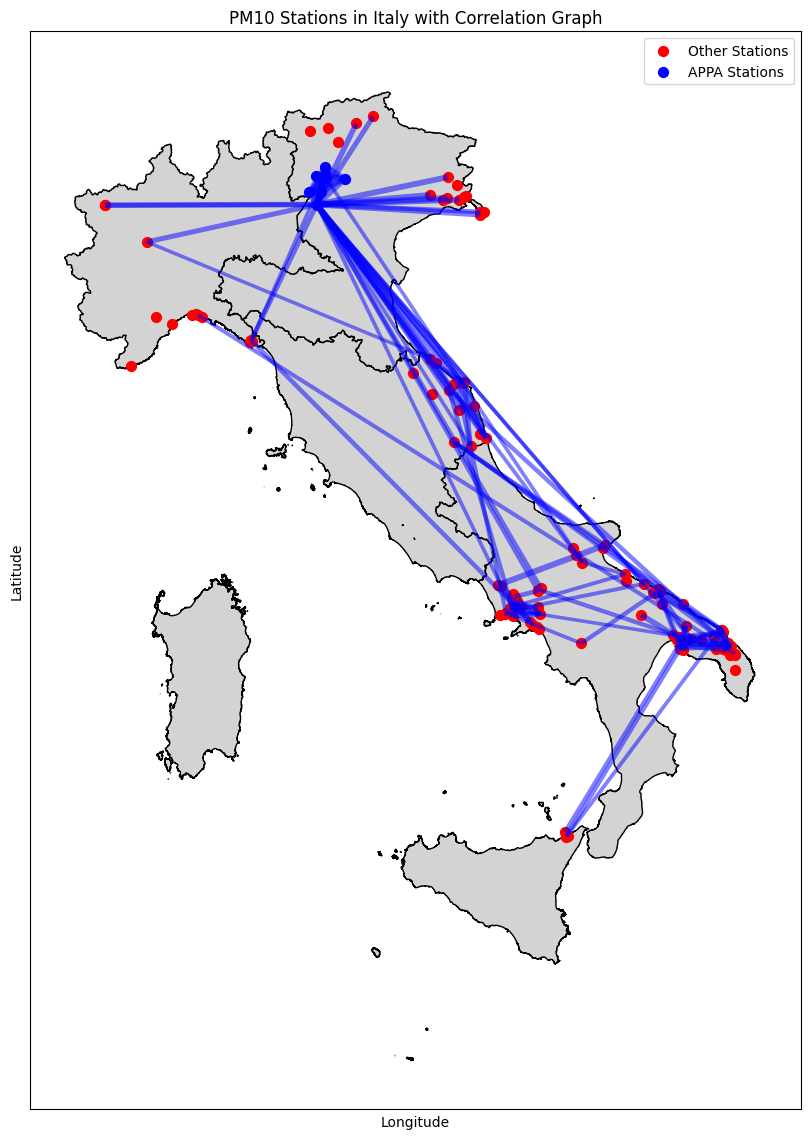

In [80]:
# code from: https://github.com/napo/geopandas_esempi/blob/master/dati%20istat.ipynb
ripartizioni_geografiche = gpd.read_file("Limiti01012018" + os.sep + "RipGeo01012018" + os.sep + "RipGeo01012018_WGS84.shp")
ripartizioni_geografiche = ripartizioni_geografiche.to_crs(epsg=4326)
#===============================================================================

df_merged_appa_eea = pd.read_csv("appa-eea-merged.csv")

# prepare the data
df_merged_appa_eea["Datetime"] = pd.to_datetime(df_merged_appa_eea["Data"]+' '+df_merged_appa_eea["Ora"].astype(str)+':00')
df_merged_appa_eea["Station_Name"] = df_merged_appa_eea["Comune"] + ' ' + df_merged_appa_eea["Stazione"]

# consider only PM10
df_merged_appa_eea = df_merged_appa_eea[df_merged_appa_eea["Inquinante"] == "PM10"]

# count unique stations
unique_stations = df_merged_appa_eea['Stazione'].unique()
num_stations = len(unique_stations)
print(f"Number of unique stations: {num_stations}")

stations_df = df_merged_appa_eea.groupby('Stazione').agg({
    'Latitudine': 'first',
    'Longitudine': 'first',
    'Comune': 'first'
}).reset_index()

gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['Longitudine'], stations_df['Latitudine']),
    crs="EPSG:4326"
)
gdf_appa = gdf[gdf['Comune'] == 'APPA']
gdf_other = gdf[gdf['Comune'] != 'APPA']

# -----------------------------
# Compute correlation between stations
# -----------------------------
pivot_df = df_merged_appa_eea.pivot_table(index='Datetime', columns='Stazione', values='Valore')
corr_matrix = pivot_df.corr()

# Create graph
G = nx.Graph()
for idx, row in stations_df.iterrows():
    G.add_node(row['Stazione'], pos=(row['Longitudine'], row['Latitudine']))

# Add edges above threshold
threshold = 0.5
for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j:
            corr = corr_matrix.loc[i,j]
            if corr >= threshold:
                G.add_edge(i, j, weight=corr)

# -----------------------------
# Plot map and stations
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 14))
ripartizioni_geografiche.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_other.plot(ax=ax, color='red', markersize=50, label='Other Stations')
gdf_appa.plot(ax=ax, color='blue', markersize=50, label='APPA Stations')

# Draw correlation edges
pos = {row['Stazione']:(row['Longitudine'], row['Latitudine']) for idx, row in stations_df.iterrows()}
edges = G.edges(data=True)
weights = [d['weight']*5 for (u,v,d) in edges]  # scale for visibility

nx.draw_networkx_edges(G, pos, ax=ax, width=weights, edge_color='blue', alpha=0.5)

ax.set_title("PM10 Stations in Italy with Correlation Graph")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()